In [1]:
# !pip install keras-tuner

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score, recall_score, precision_score, f1_score
import keras_tuner as kt

In [ ]:
# ==================================================================================
# 0. 스타일 및 폰트 설정
# ==================================================================================
# 시각화 그래프의 배경 스타일과 한글 폰트 깨짐 방지를 위한 설정
sns.set_style("whitegrid")
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호(-) 깨짐 방지

# ==================================================================================
# 1. 데이터 로드 및 uuid 기준 분리
#    메타 데이터 보존
# ==================================================================================
load_dir = r'D:\Semi2\INT\SCA_Risk_Prediction'

print("📂 데이터 로딩 및 개인 ID 기준 분리 중...")

# 1. 파일 로드
# X: 신호데이터, y: 라벨, g: uuid, t: 시간정보
try:
    # 정상군(Normal) 데이터 로드
    X_normal = np.load(os.path.join(load_dir, 'X_normal.npy'))
    y_normal = np.load(os.path.join(load_dir, 'y_normal.npy'))
    g_normal = np.load(os.path.join(load_dir, 'groups_normal.npy')) # uuid
    t_normal = np.load(os.path.join(load_dir, 'times_normal.npy'))  # 시간 구간
    
    # 급성 심정지군 (SCA - 급성 심정지) 데이터 로드
    X_sca = np.load(os.path.join(load_dir, 'X_sca.npy'))
    y_sca = np.load(os.path.join(load_dir, 'y_sca.npy'))
    g_sca = np.load(os.path.join(load_dir, 'groups_sca.npy'))       # uuid
    t_sca = np.load(os.path.join(load_dir, 'times_sca.npy'))        # 시간 구간
except Exception as e:
    print(f"❌ 데이터 로드 실패: {e}")
    exit()

📂 데이터 로딩 및 개인 ID 기준 분리 중...


In [ ]:
# 2. 개인 ID 기준 분리 함수 (메타 데이터 g, t 포함)
# 그룹 기반 분할
# [중요] 의료 데이터에서는 한 개인의 데이터가 Train과 Test에 섞여 들어가면 
# 모델이 개인의 고유 특성을 외워버리는 '데이터 누수(Data Leakage)'가 발생
# 이를 방지하기 위해 반드시 개인 uuid를 기준으로 데이터를 분할
# 80% 학습, 20% 테스트
def split_group_wise(X, y, groups, times, group_name="Data", test_ratio=0.2):
    unique_ids = np.unique(groups) # 중복 제거된 고유 개인 ID 목록 추출
    
    # 개인 ID 리스트를 무작위로 Train/Test 그룹으로 분할
    train_ids, test_ids = train_test_split(unique_ids, test_size=test_ratio, random_state=42)
    
    # 분할 결과 출력
    print(f"\n🔹 [{group_name}] 그룹 분할 결과")
    print(f" - 전체 인원: {len(unique_ids)}명")
    print(f" - Train ({len(train_ids)}명): {sorted(train_ids)}")
    print(f" - Test  ({len(test_ids)}명): {sorted(test_ids)}")
    
    # 전체 데이터에서 Train ID에 속하는지, Test ID에 속하는지 마스킹(True/False) 배열 생성
    train_mask = np.isin(groups, train_ids)
    test_mask = np.isin(groups, test_ids)
    
    # 마스킹을 사용하여 실제 데이터 분할 및 반환
    # (Test셋은 시각화를 위해 개인 ID와 시간정보도 함께 반환)
    return (X[train_mask], X[test_mask], 
            y[train_mask], y[test_mask], 
            groups[test_mask], times[test_mask]) # 테스트셋의 메타정보 반환

# 3. 분리 수행 (정상군과 위험군 각각 분리)
X_train_n, X_test_n, y_train_n, y_test_n, g_test_n, t_test_n = split_group_wise(
    X_normal, y_normal, g_normal, t_normal, group_name="정상군(Normal)")

X_train_s, X_test_s, y_train_s, y_test_s, g_test_s, t_test_s = split_group_wise(
    X_sca, y_sca, g_sca, t_sca, group_name="급성 심정지군(SCA)")

# 4. 데이터 합치기 (Concatenate)
# 정상군 Train + 급성 심정지군 Train -> 전체 Train Set
X_train = np.concatenate((X_train_n, X_train_s), axis=0)
y_train = np.concatenate((y_train_n, y_train_s), axis=0)

# 정상군 Test + 급성 심정지군 Test -> 전체 Test Set
X_test = np.concatenate((X_test_n, X_test_s), axis=0)
y_test = np.concatenate((y_test_n, y_test_s), axis=0)

# 시각화를 위한 메타 데이터 합치기 (Test set만 필요)
g_test_combined = np.concatenate((g_test_n, g_test_s), axis=0)  # 개인 ID
t_test_combined = np.concatenate((t_test_n, t_test_s), axis=0)  # 시간 구간 정보

# 5. 차원 확장 (CNN 입력용)
# CNN(Conv1D)은 입력으로 (샘플수, 시퀀스길이, 채널수)의 3차원 형태를 요구
# 현재 (N, 1024) 형태를 (N, 1024, 1) 형태로 변환
X_train = np.expand_dims(X_train, axis=-1)
X_test_cnn = np.expand_dims(X_test, axis=-1) # 변수명 X_test_cnn으로 맞춤

print(f"✅ 데이터 준비 완료")
print(f" - Train Shape: {X_train.shape}")
print(f" - Test Shape : {X_test_cnn.shape}")

# 6. 시각화용 DataFrame 생성
# 예측이 끝난 후, 어떤 환자의 어떤 시간대 데이터가 위험하게 예측되었는지 분석하기 위함
test_full = pd.DataFrame({
    'uuid': g_test_combined,
    'Target': y_test,   # 0: 정상, 1: 급성 심정지
    'Time_before_VF': t_test_combined
})


🔹 [정상군(Normal)] 그룹 분할 결과
 - 전체 인원: 18명
 - Train (14명): ['16273', '16420', '16483', '16773', '16786', '17052', '17453', '18177', '18184', '19088', '19090', '19093', '19140', '19830']
 - Test  (4명): ['16265', '16272', '16539', '16795']

🔹 [급성 심정지군(SCD)] 그룹 분할 결과
 - 전체 인원: 13명
 - Train (10명): ['31', '32', '33', '35', '36', '37', '43', '44', '48', '51']
 - Test  (3명): ['30', '47', '50']
✅ 데이터 준비 완료
 - Train Shape: (1440, 1024, 1)
 - Test Shape : (420, 1024, 1)


In [ ]:
# ==================================================================================
# 2. 베이지안 최적화를 위한 HyperModel 설계
# ==================================================================================
def build_hyper_model(hp):
    """
    hp: HyperParameters 객체 (탐색할 범위를 지정)
    """
    model = models.Sequential(name="SCA_Bayesian_Model")
    model.add(layers.Input(shape=(1024, 1)))
    
    # [검색 1] Conv1D 레이어의 필터 수와 커널 크기 탐색
    # hp.Int: 정수 범위 내에서 탐색
    # hp.Choice: 지정된 값 중에서 선택
    filters_1 = hp.Int('filters_1', min_value=16, max_value=64, step=16)
    kernel_1 = hp.Choice('kernel_1', values=[4, 8, 16])
    
    model.add(layers.Conv1D(filters=filters_1, kernel_size=kernel_1, strides=8, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling1D(pool_size=2))
    
    # [검색 2] 층을 하나 더 쌓을지 말지 결정 (구조 탐색)
    if hp.Boolean('add_extra_conv_layer'):
        filters_2 = hp.Int('filters_2', min_value=16, max_value=64, step=16)
        model.add(layers.Conv1D(filters=filters_2, kernel_size=kernel_1, strides=1, padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.ReLU())
        model.add(layers.MaxPooling1D(pool_size=2))

    # [분류기]
    model.add(layers.Flatten())
    
    # [검색 3] Dense 레이어 노드 수 탐색
    dense_units = hp.Int('dense_units', min_value=32, max_value=128, step=32)
    model.add(layers.Dense(dense_units, activation='relu'))
    
    # [검색 4] Dropout 비율 탐색
    dropout_rate = hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1)
    model.add(layers.Dropout(dropout_rate))
    
    # 출력층
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # [검색 5] 학습률(Learning Rate) 탐색
    lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy']) # 의료 데이터는 Recall이 중요하지만 튜닝 안정성을 위해 acc/loss 사용
    return model

In [ ]:
# ==================================================================================
# 3. Bayesian Optimization 튜너 설정 및 실행
# ==================================================================================
print("\n🔍 베이지안 최적화(Bayesian Optimization) 시작...")

tuner = kt.BayesianOptimization(
    build_hyper_model,
    objective='val_loss',     # 검증 손실을 최소화하는 방향으로 탐색
    max_trials=10,            # ✅ 총 시도할 모델 조합의 수 (시간에 따라 조절하세요: 10~50 권장)
    executions_per_trial=1,   # 각 조합마다 몇 번 학습해서 평균낼지 (1이면 속도 우선)
    directory='kt_dir',       # 로그 저장 폴더
    project_name='sca_bayesian_search',
    overwrite=True            # 실행할 때마다 새로 검색
)

# 튜너 검색 실행
# (검색 단계에서는 Epoch를 조금 짧게 잡고, EarlyStopping을 강력하게 줍니다)
stop_early = callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(X_train, y_train, 
             epochs=15, 
             validation_data=(X_test_cnn, y_test), 
             callbacks=[stop_early],
             verbose=1)

Trial 10 Complete [00h 00m 03s]
val_loss: 0.03462766110897064

Best val_loss So Far: 0.019436215981841087
Total elapsed time: 00h 00m 40s


In [7]:
# ==================================================================================
# 4. 최적의 모델(Best Model) 추출 및 재학습
# ==================================================================================
# 가장 성능이 좋았던 하이퍼파라미터 가져오기
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
✅ 최적의 하이퍼파라미터 발견:
- Conv1 필터 수: {best_hps.get('filters_1')}
- 커널 크기: {best_hps.get('kernel_1')}
- 추가 Conv 층 사용 여부: {best_hps.get('add_extra_conv_layer')}
- Dense 노드 수: {best_hps.get('dense_units')}
- Dropout 비율: {best_hps.get('dropout_rate')}
- 학습률: {best_hps.get('learning_rate')}
""")

# 최적의 파라미터로 모델 새로 생성
model = tuner.hypermodel.build(best_hps)

print("\n🚀 최적화된 모델로 최종 학습 시작...")
# 최종 학습은 Epoch를 넉넉하게 주고 진행
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_cnn, y_test),
    callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=1
)


✅ 최적의 하이퍼파라미터 발견:
- Conv1 필터 수: 64
- 커널 크기: 8
- 추가 Conv 층 사용 여부: False
- Dense 노드 수: 64
- Dropout 비율: 0.3
- 학습률: 0.0013160349968348475


🚀 최적화된 모델로 최종 학습 시작...
Epoch 1/50
45/45 [==============================] - 1s 9ms/step - loss: 0.1783 - accuracy: 0.9389 - val_loss: 0.5545 - val_accuracy: 0.8524
Epoch 2/50
45/45 [==============================] - 0s 7ms/step - loss: 0.0095 - accuracy: 0.9993 - val_loss: 0.2076 - val_accuracy: 0.9214
Epoch 3/50
45/45 [==============================] - 0s 7ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.1080 - val_accuracy: 0.9643
Epoch 4/50
45/45 [==============================] - 0s 7ms/step - loss: 0.0045 - accuracy: 0.9986 - val_loss: 0.0734 - val_accuracy: 0.9738
Epoch 5/50
45/45 [==============================] - 0s 7ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0422 - val_accuracy: 0.9929
Epoch 6/50
45/45 [==============================] - 0s 7ms/step - loss: 0.0026 - accuracy: 0.9993 - val_loss: 0.0499 - val_accuracy: 0.9905


📊 상세 시각화 생성 중...
14/14 [==============================] - 0s 1ms/step


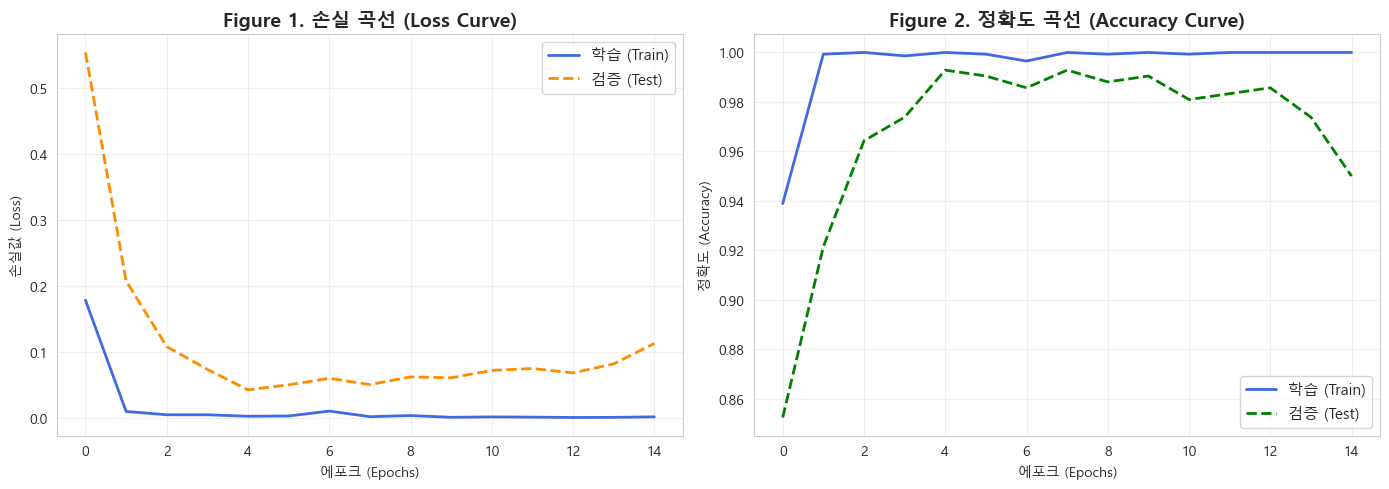

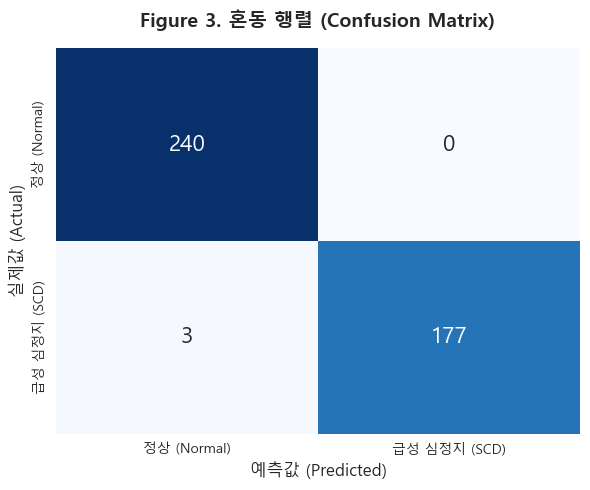

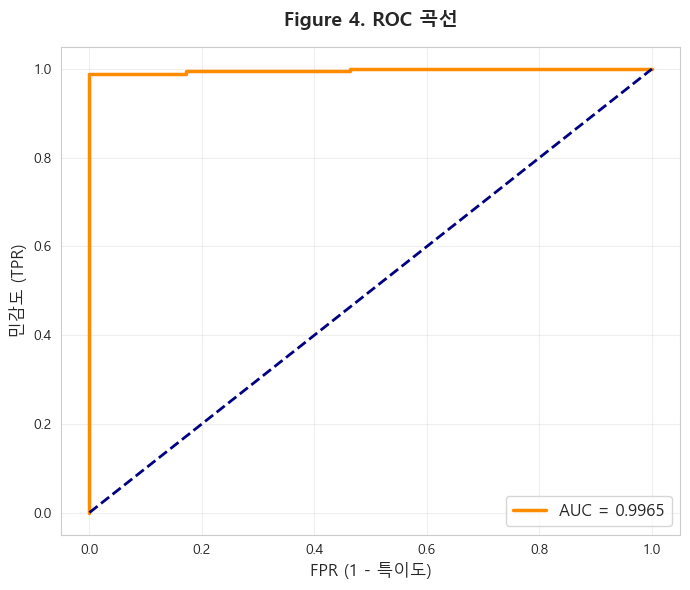

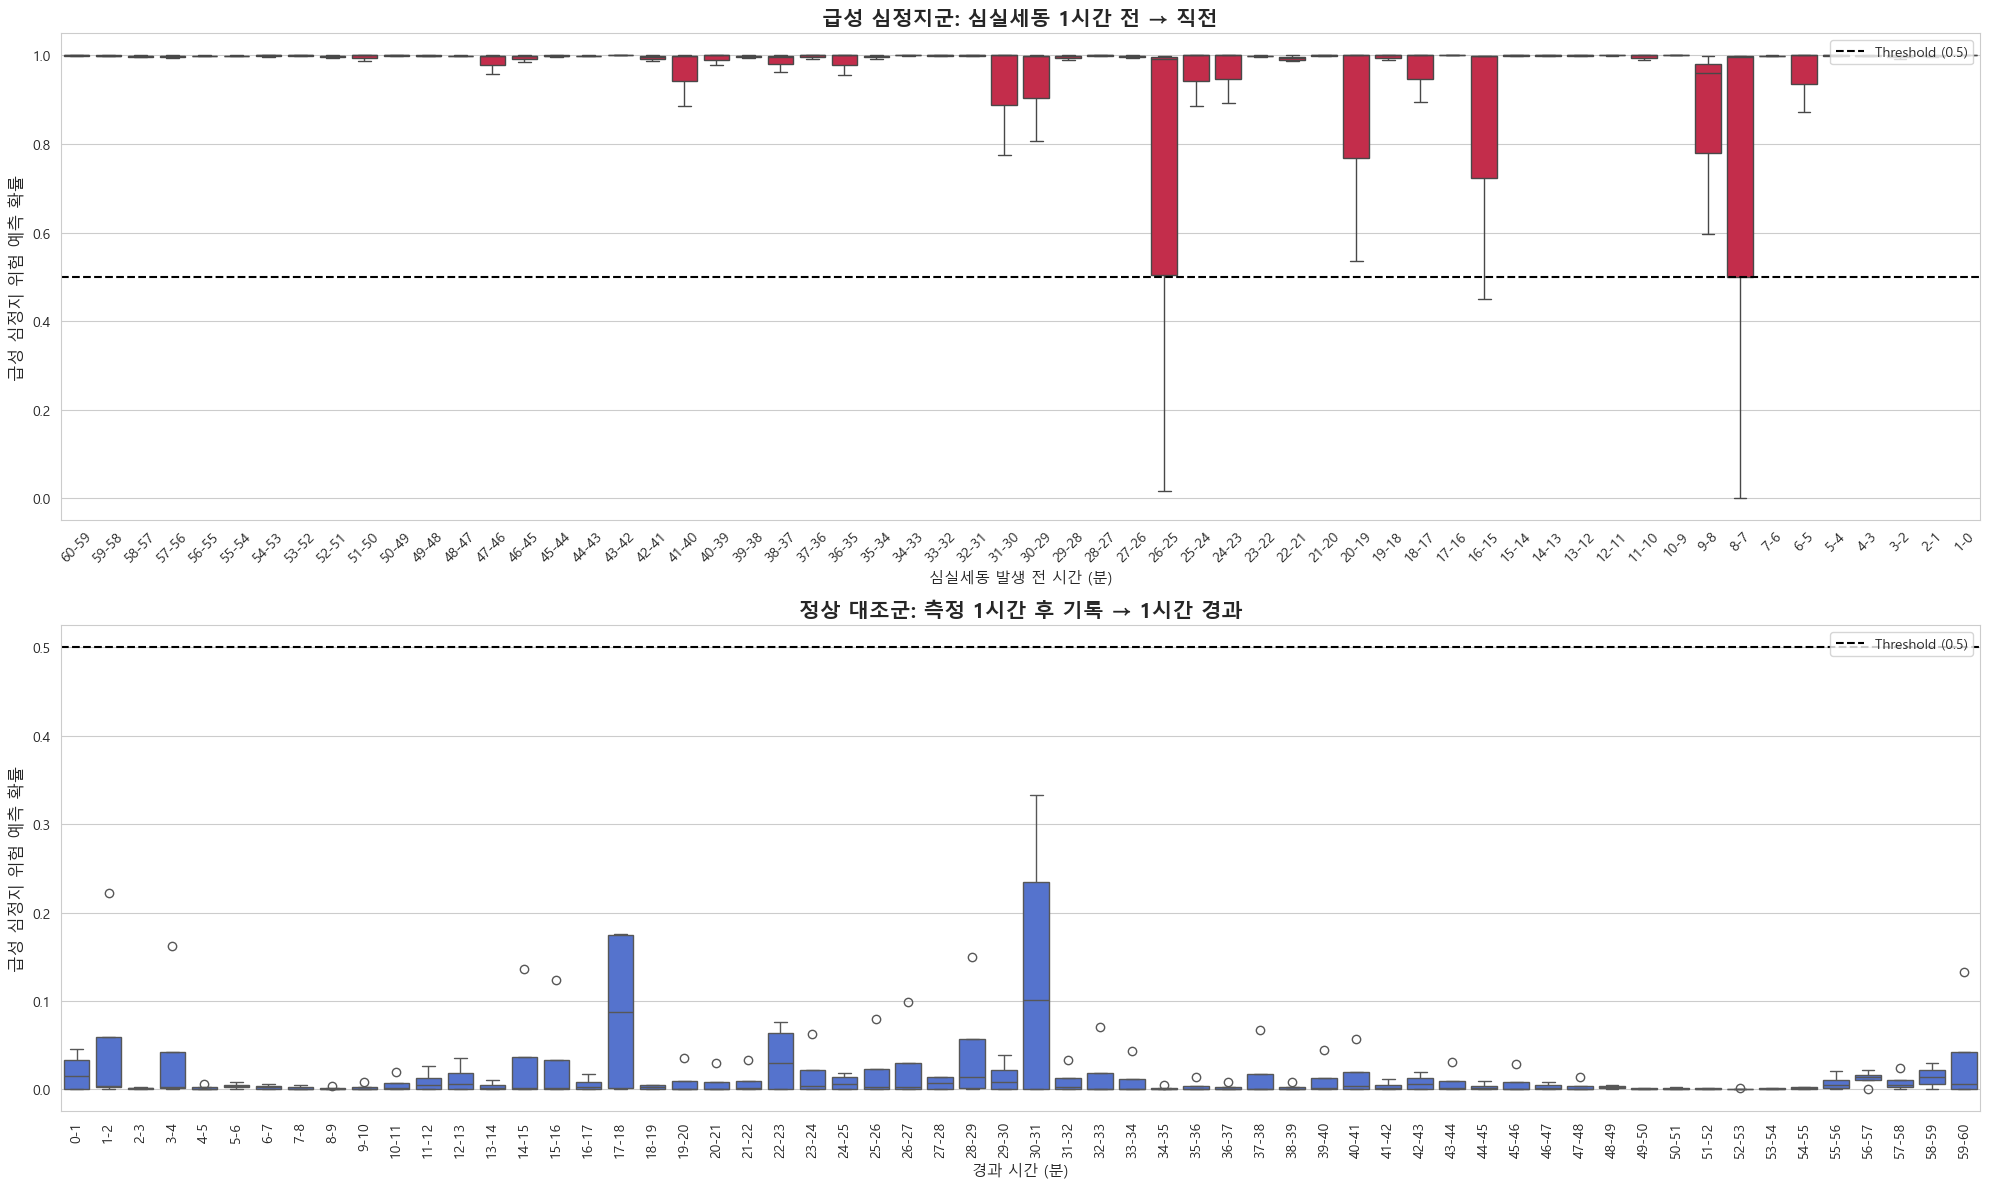


[ 📝 최종 모델 성능 평가 ]
         지표 (Metric)   Value
0     정확도 (Accuracy)  0.9929
1  민감도 (Sensitivity)  0.9833
2  특이도 (Specificity)  1.0000
3    정밀도 (Precision)  1.0000
4              F1 점수  0.9916
5                AUC  0.9965


In [ ]:
# ==================================================================================
# 5. 결과 시각화 및 평가 (Performance Evaluation)
# ==================================================================================
print("\n📊 상세 시각화 생성 중...")

# 예측값 생성 (확률값 & 0/1 클래스값)
y_pred_prob = model.predict(X_test_cnn).ravel() # 확률 (0.0 ~ 1.0)
y_pred = (y_pred_prob > 0.5).astype(int)        # 클래스 (0 또는 1)

# ==================================================================================
# --- Figure 1 & 2: 학습 곡선 ---
# 모델이 과적합(Overfitting) 없이 잘 학습되었는지 확인하는 그래프
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# 손실(Loss) 곡선
# Train은 계속 주는데 Test가 다시 올라가면 과적합 신호
ax[0].plot(history.history['loss'], label='학습 (Train)', linewidth=2, color='royalblue')
ax[0].plot(history.history['val_loss'], label='검증 (Test)', linewidth=2, linestyle='--', color='darkorange')
ax[0].set_title('Figure 1. 손실 곡선 (Loss Curve)', fontsize=14, fontweight='bold')
ax[0].set_xlabel('에포크 (Epochs)')
ax[0].set_ylabel('손실값 (Loss)')
ax[0].legend(fontsize=11)
ax[0].grid(True, alpha=0.3)

# 정확도(Accuracy) 곡선
# 높을수록 좋음
ax[1].plot(history.history['accuracy'], label='학습 (Train)', linewidth=2, color='royalblue')
ax[1].plot(history.history['val_accuracy'], label='검증 (Test)', linewidth=2, linestyle='--', color='green')
ax[1].set_title('Figure 2. 정확도 곡선 (Accuracy Curve)', fontsize=14, fontweight='bold')
ax[1].set_xlabel('에포크 (Epochs)')
ax[1].set_ylabel('정확도 (Accuracy)')
ax[1].legend(fontsize=11)
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 해석
# 파란선(Train)과 주황/초록선(Test)이 함께 움직이는지 확인
# Epoch(학습 횟수)가 늘어날수록 Loss(손실)는 줄어들고, Accuracy(정확도)는 올라가야 이상적
# 두 선의 격차가 너무 크지 않고 안정적으로 수렴했다면 "과적합(Overfitting) 없이 모델이 안정적으로 학습되었다"고 해석

# ==================================================================================
# --- Figure 3: 혼동 행렬(Confusion matrix) ---
# 실제값과 예측값이 얼마나 일치하는지 2x2 매트릭스로 표현 (TP, TN, FP, FN 확인)
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16},
            xticklabels=['정상 (Normal)', '급성 심정지 (SCA)'], yticklabels=['정상 (Normal)', '급성 심정지 (SCA)'])
plt.title('Figure 3. 혼동 행렬 (Confusion Matrix)', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('예측값 (Predicted)', fontsize=12)
plt.ylabel('실제값 (Actual)', fontsize=12)
plt.tight_layout()
plt.show()

# 해석: 모델이 얼마나 잘 맞췄는지 4가지로 쪼개서 확인
# 왼쪽 위: 정상인을 정상으로 잘 분류한 숫자, 클수록 좋음
# 오른쪽 위: 정상인을 위험군으로 분류한 숫자, 작을수록 좋음
# 오른쪽 아래: 실제 환자(SCA)를 위험하다고 잘 맞춘 숫자, 클수록 좋음
# 왼쪽 아래: 실제 환자인데 정상이라고 놓친 숫자, 작을수록 좋음

# ==================================================================================
# --- Figure 4: ROC 커브 ---
# 임계값(Threshold) 변화에 따른 민감도(TPR)와 특이도(1-FPR)의 관계
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2.5, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('FPR (1 - 특이도)', fontsize=12)
plt.ylabel('민감도 (TPR)', fontsize=12)
plt.title('Figure 4. ROC 곡선', fontsize=14, fontweight='bold', pad=15)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 해석: 모델의 '성능 등급표'
# 주황색 선이 왼쪽 위 모서리에 가까울수록 완벽한 모델
# AUC 값:
# 0.7 ~ 0.8 = 준수함
# 0.9 이상 = 매우 우수함

# ==================================================================================
# --- Figure 5: 정상군 vs 위험군 시간대별 위험도 분석 (Boxplot) ---
# [목적] 
# 급성 심정지 환자는 심정지 시점이 다가올수록(Time -> 0) 위험 예측 확률이 높아져함
# 정상인은 시간 흐름에 상관없이 위험 확률이 낮게 유지되어야 함을 검증

# 1. 순서 정의 (라벨링 규칙에 맞춤)
# 급성 심정지군: "60-59분전", ... "1-0분전" 순으로 정렬 (심정지 임박 시점을 오른쪽으로)
sca_full_order = [f"{i}-{i-1}" for i in range(60, 0, -1)]

# 정상군: "0-1분 경과", ... "59-60분 경과" 순으로 정렬 (시간 흐름 순)
norm_full_order = [f"{i}-{i+1}" for i in range(0, 60)]

# 2. 데이터 프레임에 예측 확률 추가
test_plot_df = test_full.copy()
test_plot_df['Prob_SCA'] = y_pred_prob

# 3. [안전장치] 실제 데이터셋에 존재하는 시간대 라벨만 필터링
existing_sca = set(test_plot_df[test_plot_df['Target'] == 1]['Time_before_VF'].unique())
existing_norm = set(test_plot_df[test_plot_df['Target'] == 0]['Time_before_VF'].unique())

sca_order = [label for label in sca_full_order if label in existing_sca]
norm_order = [label for label in norm_full_order if label in existing_norm]

# 4. 시각화 그리기
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12), sharex=False)

# --- [상단] 급성 심정지군 시각화 ---
sca_df = test_plot_df[test_plot_df['Target'] == 1]

if not sca_df.empty:
    sns.boxplot(x='Time_before_VF', y='Prob_SCA', data=sca_df, 
                order=sca_order, color='crimson', ax=ax1)
    ax1.axhline(0.5, color='black', linestyle='--', label='Threshold (0.5)')    # 기준선
    ax1.set_title('급성 심정지군: 심실세동 1시간 전 → 직전', fontsize=15, fontweight='bold')
    ax1.set_ylabel('급성 심정지 위험 예측 확률', fontsize=12)
    ax1.set_xlabel('심실세동 발생 전 시간 (분)', fontsize=11)
    ax1.tick_params(axis='x', rotation=45)  # X축 라벨 45도 회전
    ax1.legend(loc='upper right')
else:
    ax1.text(0.5, 0.5, "급성 심정지군 데이터 없음", ha='center', va='center')

# --- [하단] 정상군 시각화 ---
norm_df = test_plot_df[test_plot_df['Target'] == 0]

if not norm_df.empty:
    sns.boxplot(x='Time_before_VF', y='Prob_sca', data=norm_df, 
                order=norm_order, color='royalblue', ax=ax2)
    ax2.axhline(0.5, color='black', linestyle='--', label='Threshold (0.5)')
    ax2.set_title('정상 대조군: 측정 1시간 후 기록 → 1시간 경과', fontsize=15, fontweight='bold')
    ax2.set_ylabel('급성 심정지 위험 예측 확률', fontsize=12)
    ax2.set_xlabel('경과 시간 (분)', fontsize=11)
    ax2.tick_params(axis='x', rotation=90)
    ax2.legend(loc='upper right')
else:
    ax2.text(0.5, 0.5, "정상군 데이터 없음", ha='center', va='center')

plt.tight_layout()
plt.show()

# Y축: 모델이 예측한 위험 확률 (0~1)
# 빨간 점선(0.5): 모델 급성 심정지 위험 판단 기준

# ==================================================================================
# --- 성능 지표 출력 ---
tn, fp, fn, tp = cm.ravel()

metrics_df = pd.DataFrame({
    '지표 (Metric)': ['정확도 (Accuracy)', '민감도 (Sensitivity)', '특이도 (Specificity)', '정밀도 (Precision)', 'F1 점수', 'AUC'],
    'Value': [
        accuracy_score(y_test, y_pred),
        recall_score(y_test, y_pred),               # 민감도 = Recall (실제 환자를 환자라고 맞춘 비율)
        tn / (tn + fp) if (tn + fp) > 0 else 0,     # 특이도 (실제 정상을 정상이라고 맞춘 비율)
        precision_score(y_test, y_pred),            # 정밀도 (환자라고 예측한 것 중 실제 환자 비율)
        f1_score(y_test, y_pred),                   # 정밀도와 민감도의 조화 평균
        roc_auc                                     # ROC 곡선 아래 면적
    ]
})

print("\n[ 📝 최종 모델 성능 평가 ]")
print(metrics_df.round(4))

# 해석:
# 정확도(Accuracy): 전체 데이터(급성 심정지 + 정상인) 중에서 모델이 정답을 맞힌 비율
# 민감도 (Sensitivity): 실제 심정지 환자 중에서 모델이 "위험하다"고 올바르게 찾아낸 비율
# 특이도 (Specificity): 실제 정상인 중에서 모델이 "정상이다"라고 올바르게 분류한 비율
# 정밀도 (Precision): 모델이 "위험하다(sca)"라고 경고한 사람들 중, 실제로 환자인 비율
# F1 점수 (F1-Score): 민감도와 정밀도의 조화 평균으로, 두 지표의 균형을 보여주는 점수
# AUC (Area Under Curve): 민감도와 특이도의 관계를 종합하여, 모델의 전반적인 구별 능력(변별력)을 점수화